In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot style
sns.set(style="whitegrid")

Matplotlib is building the font cache; this may take a moment.


In [5]:
import os
os.getcwd()

'/Users/jillmaisel/Applications/Job-insights'

In [ ]:
df_2024 = pd.read_excel('MSA_M2024_dl.xlsx')
df_2023 = pd.read_excel('MSA_M2023_dl.xlsx')
df_2022 = pd.read_excel('MSA_M2022_dl.xlsx')


# Combine into one dataset
df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

# Preview the data
df.head()

In [7]:
df_2024.head()
df_2024.columns
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147107 entries, 0 to 147106
Data columns (total 32 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   AREA          147107 non-null  int64  
 1   AREA_TITLE    147107 non-null  object 
 2   AREA_TYPE     147107 non-null  int64  
 3   PRIM_STATE    147107 non-null  object 
 4   NAICS         147107 non-null  int64  
 5   NAICS_TITLE   147107 non-null  object 
 6   I_GROUP       147107 non-null  object 
 7   OWN_CODE      147107 non-null  int64  
 8   OCC_CODE      147107 non-null  object 
 9   OCC_TITLE     147107 non-null  object 
 10  O_GROUP       147107 non-null  object 
 11  TOT_EMP       147107 non-null  object 
 12  EMP_PRSE      147107 non-null  object 
 13  JOBS_1000     147107 non-null  object 
 14  LOC_QUOTIENT  147107 non-null  object 
 15  PCT_TOTAL     0 non-null       float64
 16  PCT_RPT       0 non-null       float64
 17  H_MEAN        147107 non-null  object 
 18  A_ME

In [9]:
relevant_titles = ['Data Scientist', 'Data Analyst', 'Machine Learning Engineer']

df_2024_filtered = df_2024[df_2024['OCC_TITLE'].str.contains('|'.join(relevant_titles), case=False)]
df_2023_filtered = df_2023[df_2023['OCC_TITLE'].str.contains('|'.join(relevant_titles), case=False)]
df_2022_filtered = df_2022[df_2022['OCC_TITLE'].str.contains('|'.join(relevant_titles), case=False)]

In [11]:
df_2024_filtered.loc[:, 'Year'] = 2024
df_2023_filtered.loc[:, 'Year'] = 2023
df_2022_filtered.loc[:, 'Year'] = 2022

In [12]:
combined_df = pd.concat([df_2022_filtered, df_2023_filtered, df_2024_filtered])

In [14]:
final_df = combined_df[['Year', 'OCC_TITLE', 'AREA_TITLE', 'TOT_EMP', 'A_MEAN']].copy()
final_df.columns = ['Year', 'Job Title', 'MetroArea', 'Total Employed', 'MeanSalary']

,Year,Job Title,MetroArea,Total Employed,MeanSalary
91293,2024,Data Scientists,"New York-Newark-Jersey City, NY-NJ",19810.0,139810.0
76052,2024,Data Scientists,"Los Angeles-Long Beach-Anaheim, CA",10030.0,130550.0
118185,2024,Data Scientists,"San Francisco-Oakland-Fremont, CA",9350.0,164690.0
33040,2024,Data Scientists,"Dallas-Fort Worth-Arlington, TX",8630.0,119130.0
139824,2024,Data Scientists,"Washington-Arlington-Alexandria, DC-VA-MD-WV",8530.0,143670.0
16963,2024,Data Scientists,"Boston-Cambridge-Newton, MA-NH",8220.0,138180.0
118905,2024,Data Scientists,"San Jose-Sunnyvale-Santa Clara, CA",6570.0,225590.0
122927,2024,Data Scientists,"Seattle-Tacoma-Bellevue, WA",6100.0,163640.0
7259,2024,Data Scientists,"Atlanta-Sandy Springs-Roswell, GA",5940.0,114960.0
26297,2024,Data Scientists,"Chicago-Naperville-Elgin, IL-IN",5840.0,119790.0


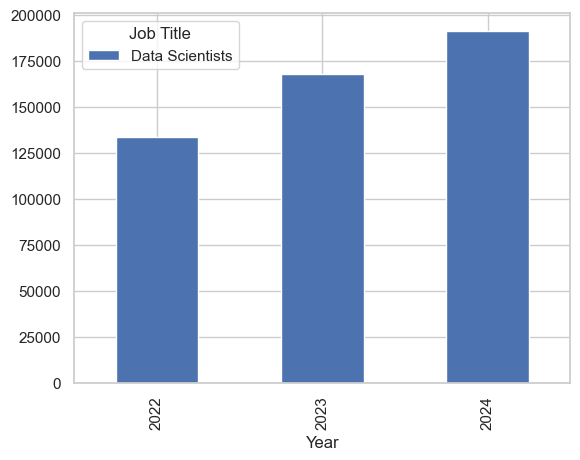

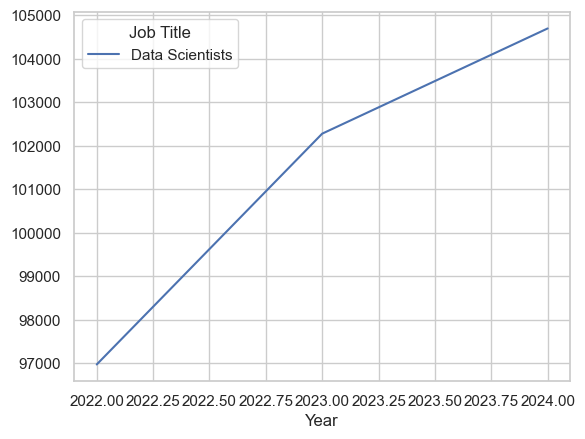

In [20]:
# Convert 'Total Employed' and 'MeanSalary' to numeric
final_df['Total Employed'] = pd.to_numeric(final_df['Total Employed'], errors='coerce')
final_df['MeanSalary'] = pd.to_numeric(final_df['MeanSalary'], errors='coerce')

# Jobs over time
final_df.groupby(['Year', 'Job Title'])['Total Employed'].sum().unstack().plot(kind='bar')

# Salary trends
final_df.groupby(['Year', 'Job Title'])['MeanSalary'].mean().unstack().plot(kind='line')

# Top metros for Data Scientist jobs in 2024
final_df[(final_df['Year'] == 2024) & (final_df['Job Title'].str.contains('Data Scientist'))] \
    .sort_values(by='Total Employed', ascending=False).head(10)



In [22]:
top10_2024_metros = final_df[final_df['Year'] == 2024] \
    .groupby('MetroArea')['Total Employed'].sum() \
    .sort_values(ascending=False).head(10).index.tolist()

In [23]:
top10_trends_df = final_df[final_df['MetroArea'].isin(top10_2024_metros)]

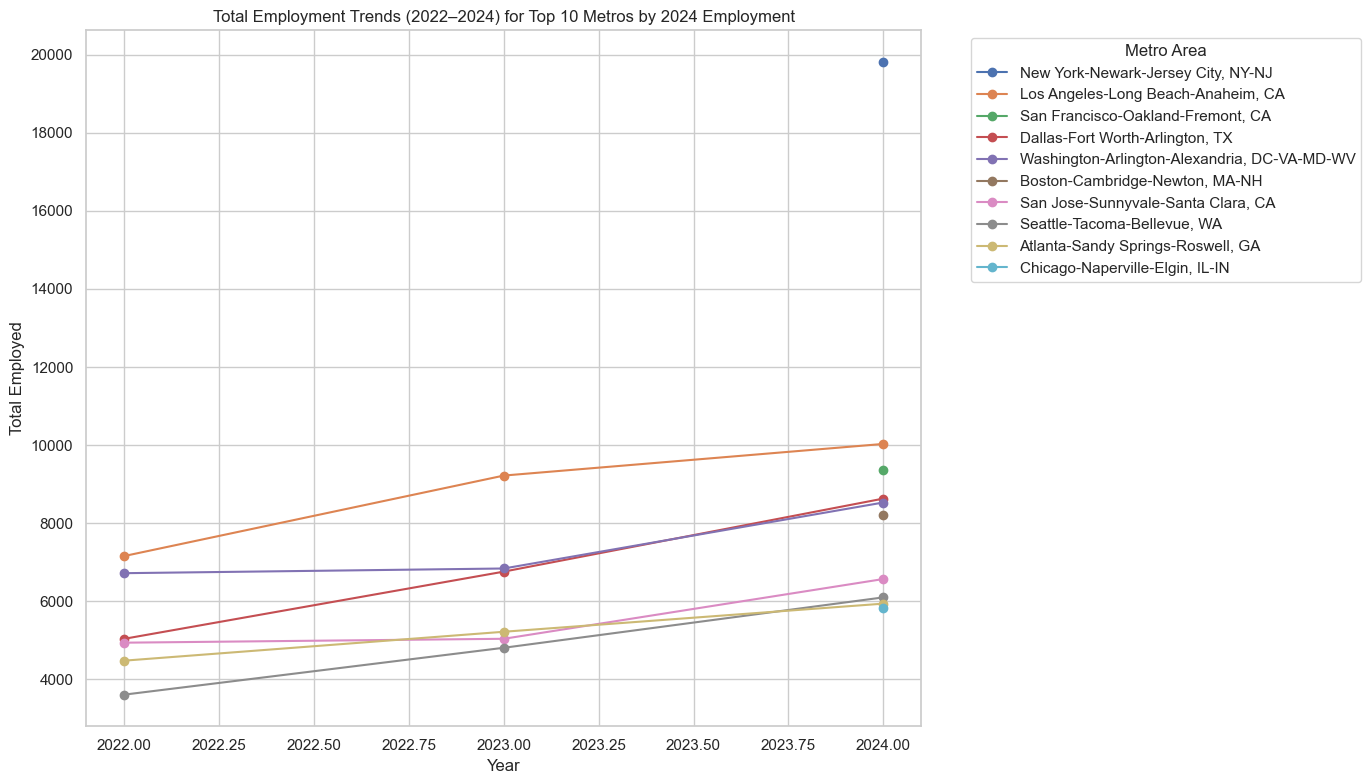

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

for metro in top10_2024_metros:
    metro_data = top10_trends_df[top10_trends_df['MetroArea'] == metro] \
        .groupby('Year')['Total Employed'].sum()
    plt.plot(metro_data.index, metro_data.values, marker='o', label=metro)

plt.title('Total Employment Trends (2022–2024) for Top 10 Metros by 2024 Employment')
plt.xlabel('Year')
plt.ylabel('Total Employed')
plt.legend(title='Metro Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

In [28]:
employment_pivot = top10_trends_df.pivot_table(
    index='MetroArea',
    columns='Year',
    values='Total Employed',
    aggfunc='sum'
).loc[top10_2024_metros]  # To keep the order same as in the chart
employment_pct_change = employment_pivot.pct_change(axis=1, fill_method=None) * 100
employment_pct_change = employment_pct_change.round(1)


In [30]:
combined_df = employment_pivot.dropna().astype(int).copy()

# Append % change below each year
for year in [2023, 2024]:
    pct_col = f"{year} % Change"
    combined_df[pct_col] = employment_pct_change[year].map(lambda x: f"{x:.1f}%" if pd.notnull(x) else "")


In [31]:
combined_df.style.set_caption("Total Employment and YoY % Change by Metro Area (2022–2024)")

Year,2022,2023,2024,2023 % Change,2024 % Change
MetroArea,,,,,
"Los Angeles-Long Beach-Anaheim, CA",7160,9220,10030,28.8%,8.8%
"Dallas-Fort Worth-Arlington, TX",5040,6760,8630,34.1%,27.7%
"Washington-Arlington-Alexandria, DC-VA-MD-WV",6720,6840,8530,1.8%,24.7%
"San Jose-Sunnyvale-Santa Clara, CA",4940,5040,6570,2.0%,30.4%
"Seattle-Tacoma-Bellevue, WA",3610,4810,6100,33.2%,26.8%
"Atlanta-Sandy Springs-Roswell, GA",4480,5220,5940,16.5%,13.8%
